In [40]:
# 10折交叉验证处理数据
import numpy as np  # 导入numpy包
import pandas as pd  # 导入pandas包
from sklearn.model_selection import KFold  # 从sklearn导入KFold包
# from sklearn.model_selection import RepeatedKFold
# rkf = RepeatedKFold(n_splits=10, n_repeats=10) #10次10折交叉验证
def Ten_Flod_spilt(fold,data,label):
    '''
    param fold: 要取第几折的数据。如要取第5折则 flod=5
    param data: 需要分块的数据
    param label: 对应的需要分块标签
    return: 对应折的训练集、测试集和对应的标签
    '''
    split_list = []
    kf = KFold(n_splits=10)
    for train, test in kf.split(data):
        split_list.append(train.tolist())
        split_list.append(test.tolist())
    train,test=split_list[2 * fold],split_list[2 * fold + 1]
    return  data[train], data[test], label[train], label[test]  #已经分好块的数据集

GradientDescent：93.01952027168056%
Least square method：92.97642440889588%
SKlearn：93.12790085597558%


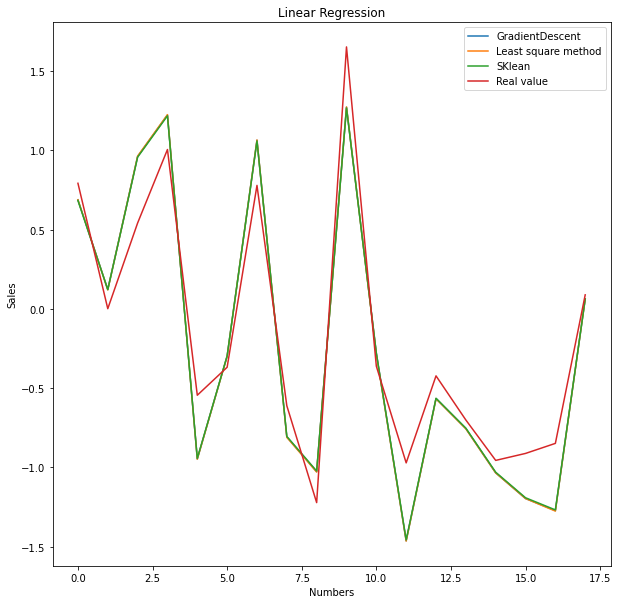

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn import linear_model
class GradientDescent_MultiLine:
    def __init__(self, lr, epochs):
        self.lr = lr  # 学习率，用来控制步长（权重调整幅度）
        self.epochs = epochs  # 循环迭代的次数
        self.lose = []  # 损失值计算（损失函数）：均方误差

    '''根据提供的训练数据对模型进行训练'''

    def fit(self, x, y):
        x = np.asarray(x)
        y = np.asarray(y)
        y = np.squeeze(y)  # 去掉冗余的维度

        self.w = np.zeros(1 + x.shape[1])  # 初始权重，权重向量初始值为0（或任何其他值），长度比X的特征数量多1（多出来的为截距）

        # 开始训练
        for i in range(self.epochs):
            y_hat = np.dot(x, self.w[1:]) + self.w[0]  # 计算预测值
            error = y - y_hat  # 计算真实值与预测值之间的差距
            self.lose.append(np.sum(error ** 2) / 2 + 0.1* np.dot(self.w.T, self.w))  # 将损失加入到损失列表中，使用L2范数正则化
            #print("迭代次数:{0},进度：{1}%".format(i + 1, 100.0 * (i + 1) / self.epochs), "  loss:", np.sum(error ** 2) / 2)
            # j <- j + α * sum((y - y_hat) * x(j))
            x_=np.c_[np.ones([x.shape[0],1]),x]
            #self.w[0] += self.lr * np.sum(error)
            #self.w[1:] += self.lr * np.dot(x.T, error)
            I=np.identity(x_.shape[1])
            self.w=self.w-self.lr*(np.dot((np.dot(x_.T, x_)+0.2*I), self.w)-np.dot(x_.T, y))

    '''样本进行预测'''

    def predict(self, x):
        x = np.asarray(x)  # 测试样本
        result = np.dot(x, self.w[1:]) + self.w[0]  # 预测结果
        return result

    '''损失收敛图'''

    def loss_ans_show(self):
        if len(self.lose) == 0:
            print("Error")
            return
        x = range(len(self.lose))
        plt.plot(x, self.lose, 'r', label='loss function')
        plt.title('loss convergence')
        plt.ylabel("loss")
        plt.xlabel("iter")
        plt.legend()
        plt.show()


'''   
函数名：lms(least square method)
功能：最小二乘法
'''


def lms(x_train, x_test, y_train, y_test):
    x_train_=np.c_[np.ones([x_train.shape[0],1]),x_train]
    x_test_=np.c_[np.ones([x_test.shape[0],1]),x_test]
    theta_n = np.dot(np.dot(inv(np.dot(x_train_.T, x_train_)+0.1*np.eye(x_train_.shape[1])), x_train_.T), y_train)  # theta = (X`X)^(-1)X`Y，其中X`表示X的转置，使用L2范数正则化
    y_pre = np.dot(x_test_, theta_n)
    mse = np.average((y_test - y_pre) ** 2)
    return theta_n, y_pre, mse


"""
函数名：fit_transform
功能：对数据进行标准化处理,即均值为0，标准差为1
"""


def fit_transform(x):
    x = np.asarray(x)
    std_ = np.std(x, axis=0)  # 标准差
    mean_ = np.mean(x, axis=0)  # 均值
    return (x - mean_) / std_


if __name__ == '__main__':

    '''载入数据'''
    
    data=pd.read_csv('5_train.csv')
    X = np.asarray(data.get(['TV','radio','newspaper']))
    y = np.asarray(data.get('sales'))
    X_s = fit_transform(X)
    y_s = fit_transform(y)

    # for i in range(10):
    #     x_train, x_test, y_train, y_test = Ten_Flod_spilt(i,X_s,y_s)
    x_train, x_test, y_train, y_test = Ten_Flod_spilt(0,X_s,y_s)
    '''1.梯度下降法'''
    if True:
        GD = GradientDescent_MultiLine(lr=0.0001, epochs=500)
        GD.fit(x_train, y_train)
        pre_gd = GD.predict(x_test)
        mse_gd = np.average((y_test - pre_gd) ** 2)
        #GD.loss_ans_show()

    '''2.最小二乘法：least square method'''
    if True:
        theta_n, pre_lms, mse_lms = lms(x_train, x_test, y_train, y_test)

    '''3.sklearn'''
    if True:
        regr = linear_model.Ridge() #Ridge回归即为加了L2范数的线性回归
        regr.fit(x_train, y_train)
        pre_sk = regr.predict(x_test)
        mse_sk = np.average((y_test - pre_sk) ** 2)

        '''模型评价'''
    #print("第{}折数据作为测试集结果：".format(i+1))
    print('GradientDescent：{}%'.format((1 - mse_gd) * 100))
    print('Least square method：{}%'.format((1 - mse_lms) * 100))
    print('SKlearn：{}%'.format((1 - mse_sk) * 100))

    '''可视化'''
    plt.figure(figsize=(10, 10))
    plt.plot(pre_gd, label="GradientDescent")
    plt.plot(pre_lms, label="Least square method")
    plt.plot(pre_sk, label="SKlean")  
    plt.plot(y_test, label="Real value")
    plt.title("Linear Regression")
    plt.xlabel("Numbers")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

clf = Ridge(alpha=1)
data=pd.read_csv('5_train.csv')
data_s = (data-data.min())/(data.max()-data.min()) 
# (data-data.min())/(data.max()-data.min()) 
# (data-data.mean())/(data.std())
X1 = np.asarray(data_s.get(['TV','radio','newspaper']))
y = np.asarray(data_s.get('sales'))
clf.fit(X1,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X1, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X1, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X1, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.005061
RMSE=0.069802
R2=83.421193%
[ 0.46045157  0.33068973 -0.00784677]
0.09504622538264329


In [43]:
X2 = np.asarray(data_s.get(['TV','radio']))
clf.fit(X2,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X2, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X2, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X2, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.005031
RMSE=0.069601
R2=83.515904%
[0.46047397 0.32913892]
0.09366144373035651


In [44]:
data_s['TV_sq'] = data_s['TV'].apply(lambda x: x**2)
X3 = np.asarray(data_s.get(['TV_sq','radio','newspaper']))
clf.fit(X3,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X3, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X3, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X3, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.008488
RMSE=0.090184
R2=71.944713%
[ 0.41766365  0.32342664 -0.01382644]
0.19173751549738566


In [45]:
data_s['radio_sq'] = data_s['radio'].apply(lambda x: x**2)
X4 = np.asarray(data_s.get(['TV','radio_sq','newspaper']))
clf.fit(X4,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X4, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X4, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X4, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.005625
RMSE=0.073289
R2=80.570702%
[ 0.46322162  0.32455693 -0.00679603]
0.14783892781975705


In [46]:
data_s['TV_cu'] = data_s['TV'].apply(lambda x: x**3)
X5 = np.asarray(data_s.get(['TV_cu','radio','newspaper']))
clf.fit(X5,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X5, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X5, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X5, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.011325
RMSE=0.104113
R2=62.950683%
[ 0.4041053   0.32390146 -0.01647011]
0.23180432004295223


In [47]:
data_s['radio_cu'] = data_s['radio'].apply(lambda x: x**3)
X6 = np.asarray(data_s.get(['TV','radio_cu','newspaper']))
clf.fit(X6,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X6, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X6, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X6, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.006732
RMSE=0.080518
R2=76.525134%
[0.46427753 0.32452227 0.00807746]
0.16820160829081887


In [48]:
X7 = np.asarray(data_s.get(['TV_cu','radio_cu','newspaper']))
clf.fit(X7,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X7, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X7, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X7, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.013225
RMSE=0.112500
R2=55.010379%
[0.40709736 0.31373971 0.00075803]
0.3050798101740514


In [49]:
X8 = np.asarray(data_s.get(['TV_sq','radio_sq','newspaper']))
clf.fit(X8,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X8, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X8, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X8, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.009168
RMSE=0.093502
R2=68.531613%
[ 0.41961065  0.31544446 -0.01191987]
0.24444035007362203


In [50]:
X9 = np.asarray(data_s.get(['TV_cu','radio_sq','newspaper']))
clf.fit(X9,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X9, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X9, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X9, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.012114
RMSE=0.107516
R2=58.997328%
[ 0.40535294  0.31464135 -0.01396095]
0.28514743026102013


In [51]:
X10 = np.asarray(data_s.get(['TV_sq','radio_cu','newspaper']))
clf.fit(X10,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X10, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X10, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X10, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.010248
RMSE=0.099034
R2=64.598855%
[0.42125309 0.31492984 0.00269093]
0.26426070722994466


In [52]:
data_s['radio_news'] = data_s['radio']*data_s['newspaper']
X11 = np.asarray(data_s.get(['TV','radio_news']))
clf.fit(X11,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X11, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X11, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X11, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.011185
RMSE=0.104013
R2=62.772311%
[0.47300791 0.36404007]
0.18674529769771303


In [53]:
data_s['news_sqrt'] = data_s['newspaper'].apply(lambda x: x**0.5)
X12 = np.asarray(data_s.get(['TV','radio','news_sqrt']))
clf.fit(X12,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X12, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X12, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X12, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.005068
RMSE=0.069853
R2=83.412071%
[ 0.46047761  0.3296443  -0.00289552]
0.09481501573947354


In [3]:
data_s['TV_min'] = data_s['TV'].apply(lambda x:x**0.2)
data_s['TV_radio']=data_s['TV']*data_s['radio']
X13 = np.asarray(data_s.get(['TV_radio','TV_min','radio','newspaper']))
clf.fit(X13,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X13, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X13, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X13, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.001193
RMSE=0.033860
R2=95.937956%
[ 0.4974528   0.4217457   0.10899676 -0.01095106]
-0.03811764712515803


In [4]:
X14 = np.asarray(data_s.get(['TV_radio','newspaper']))
clf.fit(X14,y)
print('MSE=%f'%(-0.1*cross_val_score(clf, X14, y, cv=10, scoring='neg_mean_squared_error').sum()))
print('RMSE=%f'%(-0.1*cross_val_score(clf, X14, y, cv=10, scoring='neg_root_mean_squared_error').sum()))
print('R2=%f'%(10*cross_val_score(clf, X14, y, cv=10, scoring='r2').sum())+'%')
print(clf.coef_)
print(clf.intercept_)

MSE=0.003763
RMSE=0.058731
R2=88.587106%
[ 0.72890817 -0.00653987]
0.30767189157517294


In [55]:
import joblib
joblib.dump(clf,'model.pickle') #保存

['model.pickle']